# Introduction
This notebook gives an example how we do **EDA (explorative data analysis)**.

It is the first one in a series of 5 notebooks. The next 2 notebooks load the results of this notebook and implement model comparison and model interpretation respectively.  The last 2 notebooks show how to implement model training in production, as well as scoring for new data, which closes the loop of all codings you need to implement for a predictive modeling project.

For a better understanding you should have **basic knowledge of predictive modelling**, i.e. know what a logistic regression is and the meaning of tuning and cross-validation, for instance. If you still have problems with some terms you can easily google appropriate information.

As example data source the well known **titanic data set** is chosen (https://www.kaggle.com/c/titanic/data). It is therefore a classification problem with the binary target *survived/not survived*. Even though you cannot compare the titanic case with a real life setting, the following steps pretty much reflect (on a small scale!) how we conduct data analysis in all our predictive modeling projects.

<br><br>
# 0 Packages and settings

We start by loading packages and do some basic settings (define data and output locations, parameters for plotting, ...). 

Furthermore the ***0_init.R*** program loads the **hmsPM** package which comprises many functions, mainly for plotting, which are frequently used in this notebook. The detailed implementation of these functions is not important for understanding the EDA approach presented here. In order to prevent you from "searching" for these functions in other packages we prefixed them by the package name (i.e. "hmsPM::").


In [1]:
setwd("C:/MY/hmsPM_R/hmsPM/inst/example")
suppressMessages(source("./code/0_init.R"))

<br><br>
# 1 ETL
We need to do some ETL (extract, transform, load) first. 
<br>
## 1.1 Read data and conduct quick check

In [2]:
df.orig = suppressMessages(read_csv(paste0(dataloc,"titanic.csv"), col_names = TRUE)) #read data

Let's do a quick check of the data:

In [3]:
options(width = 140) #get more space for printing
df.orig %>% mutate_if(is.character, as.factor) %>% summary(.) #character to factors for summary

 pclass       survived                                  name          sex           age              sibsp            parch      
 1st:323   Min.   :0.000   Connolly, Miss. Kate           :   2   female:466   Min.   : 0.1667   Min.   :0.0000   Min.   :0.000  
 2nd:277   1st Qu.:0.000   Kelly, Mr. James               :   2   male  :843   1st Qu.:21.0000   1st Qu.:0.0000   1st Qu.:0.000  
 3rd:709   Median :0.000   Abbing, Mr. Anthony            :   1                Median :28.0000   Median :0.0000   Median :0.000  
           Mean   :0.382   Abbott, Master. Eugene Joseph  :   1                Mean   :29.8811   Mean   :0.4989   Mean   :0.385  
           3rd Qu.:1.000   Abbott, Mr. Rossmore Edward    :   1                3rd Qu.:39.0000   3rd Qu.:1.0000   3rd Qu.:0.000  
           Max.   :1.000   Abbott, Mrs. Stanton (Rosa Hunt:   1                Max.   :80.0000   Max.   :8.0000   Max.   :9.000  
                           (Other)                        :1301                NA's   :263

+ We see that 38.2% of all passengers survived.
+ Some columns have missings
+ *name*, *ticket* and *cabin* seem to be useless for analysis as this information is too detailed
+ *cabin* seems to be a list of all cabins associated with a ticket (valid for several persons). Actually we can only derive this fact due to some (googled) domain knowledge  

In real data situations much more of these findings and data issues will pop up and need to be precisely reviewed usually together with business and data people.  
**It is absolutly important to fully understand the input data for a prediction problem!**

Before transforming the data we create a copy of the original data. In case of bigger datasets which take much longer to be read this helps for faster implementation in case some erroneous tansformation will be done. Actually for the very small titanic data this is not really needed.

In [4]:
df = df.orig #"save" original data

<br>  
## 1.2 Read metadata
In real life you usually have lots of input variables (features), which might be created in parallel to your data analysis implementation but on database side by a data engineer. Then it makes sense to administer the definition of the features together with some metadata (implementation status like "under construction" or "ready", typical values, comments regarding derivation, etc.) in an external tool. For a pragmatic approach an excel sheet nicely fits the requirement and can be automatically read by your program. E.g you could directly check the consistency of this datamodel.xls with the current data you load like it is done in the following. Below you see an example of such an excel sheet which we further filter on the variables we will use in our model.

In [5]:
df.meta = read_excel(paste0(dataloc,"datamodel_","titanic.xlsx"), skip = 1)
df.meta

# Check
print(setdiff(colnames(df), 
              df.meta$variable)) #any variables in data which cannot be found in metadata
print(setdiff(df.meta %>% filter(category == "orig") %>% .$variable, 
              colnames(df))) # any (original) variables defined in metadata which are not in data

# Filter on "ready"
df.meta_sub = df.meta %>% filter(status %in%  c("ready","derive"))

category,variable,Description (incl. Derivation),type,modeltype,Questions and Comments,status
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
orig,pclass,"- Passenger class - 1st, 2nd, 3rd",ordi,ordi,NA,ready
orig,survived,"- 0 = No, 1 = Yes",target,target,NA,ready
orig,name,NA,NA,NA,NA,NOT USE
orig,sex,"- male, female",nomi,nomi,NA,ready
orig,age,NA,metr,metr,263 missings,ready
orig,sibsp,- Number of Siblings/Spouses Aboard - 0 - 8,ordi,metr,"- Sibling: Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic -Spouse: Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiancées Ignored)",ready
orig,parch,Number of Parents/Children Aboard '_0 -5,ordi,metr,"- Parent: Mother or Father of Passenger Aboard Titanic - Child: Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic",ready
orig,ticket,Ticket Number,NA,NA,Several persons might share ticket,NOT USE
orig,fare,Passenger Fare,metr,metr,- Fare per ticket - some are 0,ready


character(0)
character(0)


<br>  
## 1.3 Feature engineering

Now one of the most important steps in predictive modeling has to be done: **Feature engineering**, i.e. deriving new information.

Even the most ambitious machine learning algorithms profit from feature engineering as it helps the algorithm to **"find the signal"**. In case of infinite data, an algorithm like deep neural nets is capable of finding all relations the features have with the target. But you will never have infinite data ... even in times of big data!

For the titanic data there is not much to do here, but in real life situations it is not unusual that you create **more new features than original input data columns**. In such cases it is often advantagous that most of the feature engineering is done on database side where the data originates.  

Keep in mind that there is no standard approach to feature engineering. The best prerequisite is domain knowledge which can guide you to important new features. Just think about which information might be related to the target, derive it and check the influence on predicting the target.

In [6]:
df$deck = as.factor(str_sub(df$cabin, 1, 1)) #deck as first character of cabin
df$familysize = df$sibsp + df$parch + 1 #add number of siblings and spouses to the number of parents and children
df %<>% group_by(ticket) %>% mutate(fare_pp = fare/n()) %>% ungroup() #fare per person (one ticket might comprise several persons)
summary(df[c("deck","familysize","fare_pp")]) 

# Define the id
df$id = 1:nrow(df)

      deck        familysize        fare_pp      
 C      :  94   Min.   : 1.000   Min.   :  0.00  
 B      :  65   1st Qu.: 1.000   1st Qu.:  7.55  
 D      :  46   Median : 1.000   Median :  8.05  
 E      :  41   Mean   : 1.884   Mean   : 14.76  
 A      :  22   3rd Qu.: 2.000   3rd Qu.: 15.01  
 (Other):  27   Max.   :11.000   Max.   :128.08  
 NA's   :1014                    NA's   :1       

<br>  
## 1.4 Define target and train/test fold  
Now we define the target and name it "target". This standard name helps in reusing the forthcoming code for other cases.

In [7]:
# Target
df = df %>% mutate(target = factor(ifelse(survived == 0, "N", "Y"), 
                                   levels = c("N","Y")), #factor needed by caret package
                   target_num = ifelse(target == "N", 0 ,1)) #numeric version for some special analysis
summary(df[c("target","target_num")])

 target    target_num   
 N:809   Min.   :0.000  
 Y:500   1st Qu.:0.000  
         Median :0.000  
         Mean   :0.382  
         3rd Qu.:1.000  
         Max.   :1.000  

At this point we already specify the train/test fold.  

Here we use a **random 70/30 split**, but just because we do not have a time related variable. It is absolutely important to **do the split time based in real life situations!** First of all you usually want to predict something in the future (e.g. "will a customer churn"), so you best simulate this by a time based split. And as variable distributions as well as relations to the target can change over time, a pure random split usually would result in an overly positive predictive performance which you will not see in your first back testing in production.  

Last but not least, using time based features like calendar-week, day-of-month, etc. might result in some overfitting which you cannot identify by a random split.

In [8]:
# Train/Test fold
df$fold = factor("train", levels = c("train", "test"))
set.seed(123)
df[sample(1:nrow(df), floor(0.3*nrow(df))),"fold"] = "test" #random 70/30 split
summary(df$fold)

train  test 
  917   392

<br><br>
# 2 Metric features: Explore and adapt
We first analyze the metric features. Therefore we initially define the names of the metric covariates in a simple character vector. In case not all of them are already of numeric type, we convert them.

In [9]:
# Define metric covariates
metr = df.meta_sub %>% filter(type == "metr") %>% .$variable
df[metr] = map(df[metr], 
               ~ hmsPM::convert_scale(., "metr"))
summary(df[metr]) 

      age               fare            fare_pp      
 Min.   : 0.1667   Min.   :  0.000   Min.   :  0.00  
 1st Qu.:21.0000   1st Qu.:  7.896   1st Qu.:  7.55  
 Median :28.0000   Median : 14.454   Median :  8.05  
 Mean   :29.8811   Mean   : 33.295   Mean   : 14.76  
 3rd Qu.:39.0000   3rd Qu.: 31.275   3rd Qu.: 15.01  
 Max.   :80.0000   Max.   :512.329   Max.   :128.08  
 NA's   :263       NA's   :1         NA's   :1       

<br>  
## 2.1 Binning

We now create a **"binned" copy of every metric feature**, i.e. we group the values into bins determined by **10 quantiles** of the metric feature.  
This binned copy is used below for some plots. 
But more importantly, we later use these newly created nominal variables as features instead of the original variables for an elastic-net algorithm.  
<br>
Even though the binning throws away some information it has several **advantages in conjunction with a "linear model"** like elastic-net (Hint: for a the tree-based model this transformation has no advantage, see also tree-related discussion below):  
+ Ability to approximate **nonlinear effects** with a linear model (since each bin can get its own effect)
+ Elegant handling of **missing values** as these can be grouped into a seperate member named "(Missing)" for instance
+ No worries about **outliers in feature space** as these are nicely grouped with non-outliers in the edge bins
+ Also **skewness** (see below) is not an issue any more due to the quantile based binning

In [10]:
# Create nominal variables for all metric variables  
metr_binned = paste0(metr,"_BINNED_")
df[metr_binned] = map(df[metr], ~ {
  # Hint: Adapt sequence increment in case you have lots of data 
  cut(., unique(quantile(., seq(0, 1, 0.1), na.rm = TRUE)), include.lowest = TRUE)  #cut by quantiles
})

# Convert missings to own level "(Missing)"
df[metr_binned] = map(df[metr_binned], 
                      ~ fct_explicit_na(., na_level = "(Missing)")) 
summary(df[metr_binned],11)

# Remove binned variables with just 1 bin
onebin = metr_binned[map_lgl(metr_binned, 
                             ~ length(levels(df[[.]])) == 1)]
print(onebin)
metr_binned = setdiff(metr_binned, onebin)

     age_BINNED_       fare_BINNED_    fare_pp_BINNED_
 [0.167,14]:107   [0,7.57]   :131   [0,6.24]   :134   
 (14,19]   :118   (7.57,7.85]:144   (6.24,7.23]:143   
 (19,22]   :108   (7.85,8.05]:146   (7.23,7.75]:146   
 (22,25]   :110   (8.05,10.5]:108   (7.75,7.9] :131   
 (25,28]   : 93   (10.5,14.5]:128   (7.9,8.05] :109   
 (28,31]   : 98   (14.5,21.7]:130   (8.05,10.5]:161   
 (31,36]   :121   (21.7,27]  :128   (10.5,13]  :136   
 (36,42]   : 96   (27,41.6]  :134   (13,26.3]  : 89   
 (42,50]   :100   (41.6,78.1]:128   (26.3,31]  :128   
 (50,80]   : 95   (78.1,512] :131   (31,128]   :131   
 (Missing) :263   (Missing)  :  1   (Missing)  :  1   

character(0)


<br>  
## 2.2 Handling of missings, outliers, skewness
When we want to use the original metric variables with **algorithms like "standard" GLM (generalized linear models, including logistic regression), SVM (support vector machines) or deep neural nets**, we now need to **care about missings, outliers and skewness** occuring in the features. 

All the following coding steps help these **non-tree-based algorithms to find the signal**. Why do we state "non-tree-based" here? Actually **all algorithms based on decision trees**, like random forest or boosted decision trees (e.g. xgboost), do not suffer from these issues: Missings are treated as a special value which can be used in all splits, feature outliers almost do not influence any tree split, feature skewness need not be handled by a montone transformation as trees are invariant to such adaptions.  

First of all we remove features with too many missings. **But how much is too many?** In classic statistical analysis you 
still see that features (or *covariates*) are removed if they contain 50% missings or more. Actually in data science when utilizing machine
learning algorithms, this threshold is much higher. It is not unusual to **keep variables with 99% missings**. This threshold is also used in the following and can be seen as a rule of thumb.  
Actually for the metric features of the titanic data are far away from this threshold.  

**Later we will care about the missings more detailed, i.e. remove them by imputation**. But for now we keep the features as is for some additional analysis.

In [11]:
# Remove covariates with too many missings from metr 
misspct = map_dbl(df[metr], 
                  ~ round(sum(is.na(.)/nrow(df)), 3)) #misssing percentage
print(misspct[order(misspct, decreasing = TRUE)]) #view in descending order
(remove = names(misspct[misspct > 0.99])) #vars to remove
metr = setdiff(metr, remove) #adapt metadata
metr_binned = setdiff(metr_binned, 
                      paste0(remove,"_BINNED_")) #keep "binned" version in sync

    age    fare fare_pp 
  0.201   0.001   0.001 


character(0)

We already create some initial plots to check whether there are **outliers or skewed distributions**. The distributions in the plots are stratified by the target. The reason behind this kind of display is explained later.

      age               fare            fare_pp      
 Min.   : 0.1667   Min.   :  0.000   Min.   :  0.00  
 1st Qu.:21.0000   1st Qu.:  7.896   1st Qu.:  7.55  
 Median :28.0000   Median : 14.454   Median :  8.05  
 Mean   :29.8811   Mean   : 33.295   Mean   : 14.76  
 3rd Qu.:39.0000   3rd Qu.: 31.275   3rd Qu.: 15.01  
 Max.   :80.0000   Max.   :512.329   Max.   :128.08  
 NA's   :263       NA's   :1         NA's   :1       

Plot 'metr' feature 'age' on 'class' target 'target'


Remove rows with missing values: age 263, target 0


Plot 'metr' feature 'fare' on 'class' target 'target'


Remove rows with missing values: fare 1, target 0


Plot 'metr' feature 'fare_pp' on 'class' target 'target'


Remove rows with missing values: fare_pp 1, target 0


[[1]]
NULL


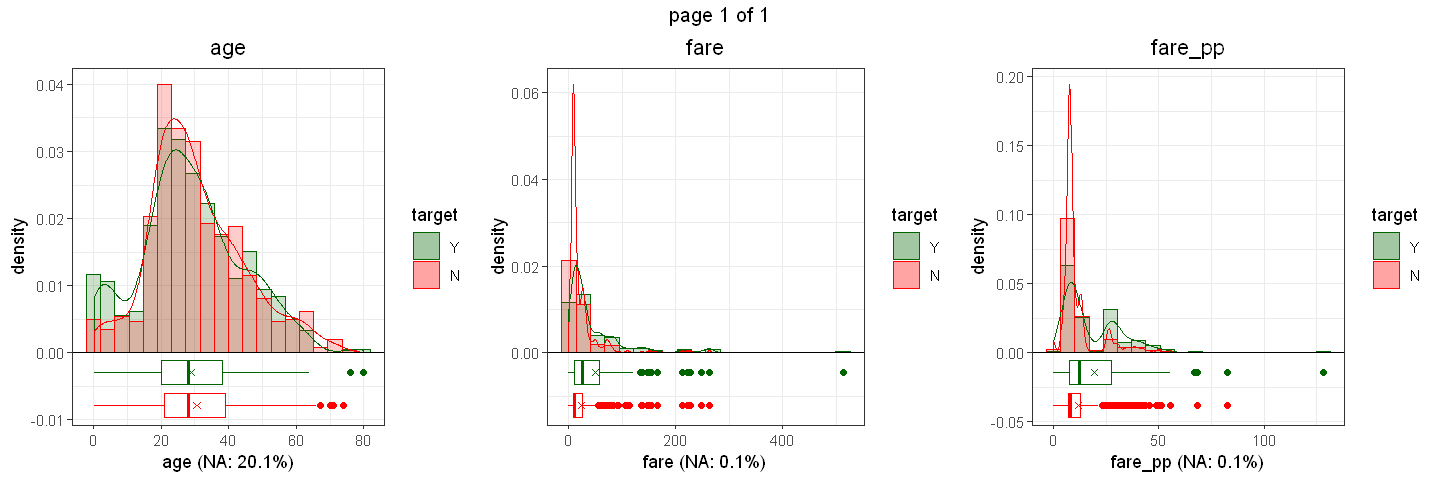

In [12]:
# Check for outliers and skewness
summary(df[metr]) 
options(warn = -1) #suppress unwanted warnings
plots = map(metr, ~ 
            hmsPM::plot_distr(x            = df[[.]], 
                              y            = df$target, 
                              feature_name = ., 
                              colors       = twocol, 
                              ylim         = c(0,1)))
options(repr.plot.width = 12, repr.plot.height = 4) #adapt this for different resolution
marrangeGrob(suppressMessages(plots), ncol = 3, nrow = 1) #arrange plots
options(warn = 0) #reset warnings

For "age" we do not see anything unusual. 

But for "fare" (and therefore also for "fare_pp") we can identify at least one clear outlier above 500. Furthermore the distribution for "fare" is highly right-skewed.  
An easy approach to handle outliers is to **winsorize the data**, i.e. set all values below the .01 quantile to the quantile value and do the same for data above the .99 quantile. Sometimes this already fixes some skewness in extreme cases.  

As we only see outliers on the right side, we conduct a one-sided winsorization.

In [13]:
# Winsorize
df[metr] = map(df[metr], 
               ~ hmsPM::winsorize(., NULL, 0.99)) #hint: one might want to plot again before deciding for forthcoming log-trafo

Skewness: The most common case are **right-skewed** variables as you often face features that are unrestricted to the right but restricted to the left by zero. This kind of skewness can often be fixed by a **log-transformation**. A more flexible alternative is the so-called *Box-Cox* trafo for which the log trafo is a special case. The Box-Cox seeks for normality which is useful but not absoutely needed. We choose a log transformation here.

In [14]:
# Log-Transform
tolog = c("fare") #variable to transform
df[paste0(tolog,"_LOG_")] = map(df[tolog], 
                                ~ {if(min(., na.rm=TRUE) <= 0) log(. - min(., na.rm = TRUE) + 1) else log(.)}) #log(x) or log(-min(x)+x) trafo
metr = map_chr(metr, 
               ~ ifelse(. %in% tolog, paste0(.,"_LOG_"), .)) #adapt metadata (and keep order)
summary(df[paste0(tolog,"_LOG_")])

   fare_LOG_    
 Min.   :0.000  
 1st Qu.:2.186  
 Median :2.738  
 Mean   :2.977  
 3rd Qu.:3.474  
 Max.   :5.574  
 NA's   :1      

<br>  
## 2.3 Plot the finalized features
We are now ready to get the final distribution plot for the metric features. This plot has several characteristics helping to judge the features:  
+ We also print the **univariate variable importance**, which, for a classification problem, is identical with the **in-sample (or "training") AUC** (area under the curve) you can achieve if you solely use one feature to predict the target. 
+ Before calculating it, we **impute the missing values with random non-missing values** from the same variable which assures that the univariate variable importance is not overly optimistic due to a restriction to the non-missing variable values. Actually also the opposite, i.e. only calculate the variable importance on the non-missing values of the feature, might comprise releveant information, e.g. hint to data leakage (see explanation below)
+ But we add the percentage of (imputed) missings to better justify the importance of the feature. 
+ The **stratification by the target** helps to identify the effect on the target.
+ The boxplots below the distributions supports in **identifying outliers** and in **comparison of the mean** (marked by the cross) and the median (marked by the bar) of the feature in the two target strata.
+ We additionally plot the effect of the binned versions of the features which sometimes is advantageous in visualizing the effect on the target (with the **dotted line showing the base ratio of the target**, i.e. 38% survival rate). E.g. if you have a metric variable with lots of data in a small range, this plot pulls apart possible effects. Do not get confused by the unequal percentage of observations for each bin which is printed in brackets behind the bin edges; this can occur in case of too few distinct values of the original variable. 
+ The binned version plot also helps in **identifying informative missings** by comparing the effect of the "(Missing)" bin with the others.


Especially the next to last bullet is important. If you already see here an effect which is **"too good to be true"**, you might have created some form of ***data leakage***. This isssue always occurs if you have some data relations in your training data that would not occur in a similar way for your future test data and therefore would result in a much lesser predictive performance for the latter. The data leakage can have several reasons: you might have incorporated **"self-predictors" or "information from the future"** as explained in more detail below. In such a case you need to fix the leakage, e.g. by removing the self-predictors from your feature vector. 

We need to emphasize at this point that we never use the analysis of the following plot to remove any metric features due to a lack of predictability for the target. Such an approach for filtering out features by utilizing all data (and therefore also the test data) is called **"data snooping"** and should be avoided at all costs as it prevents you from estimating the correct predictive capability of your data. We will let the robust machine learning algorithm decide whether and how to use all features.

fare_LOG_   fare_pp       age 
     0.67      0.64      0.52 
   fare_BINNED_ fare_pp_BINNED_     age_BINNED_ 
           0.67            0.64            0.56 
Plot 'metr' feature 'age' on 'class' target 'target'


Remove rows with missing values: age 263, target 0


Plot 'metr' feature 'fare_LOG_' on 'class' target 'target'


Remove rows with missing values: fare_LOG_ 1, target 0


Plot 'metr' feature 'fare_pp' on 'class' target 'target'


Remove rows with missing values: fare_pp 1, target 0


Plot 'nomi' feature 'age_BINNED_' on 'class' target 'target'
Plot 'nomi' feature 'fare_BINNED_' on 'class' target 'target'
Plot 'nomi' feature 'fare_pp_BINNED_' on 'class' target 'target'


[[1]]
NULL

[[2]]
NULL


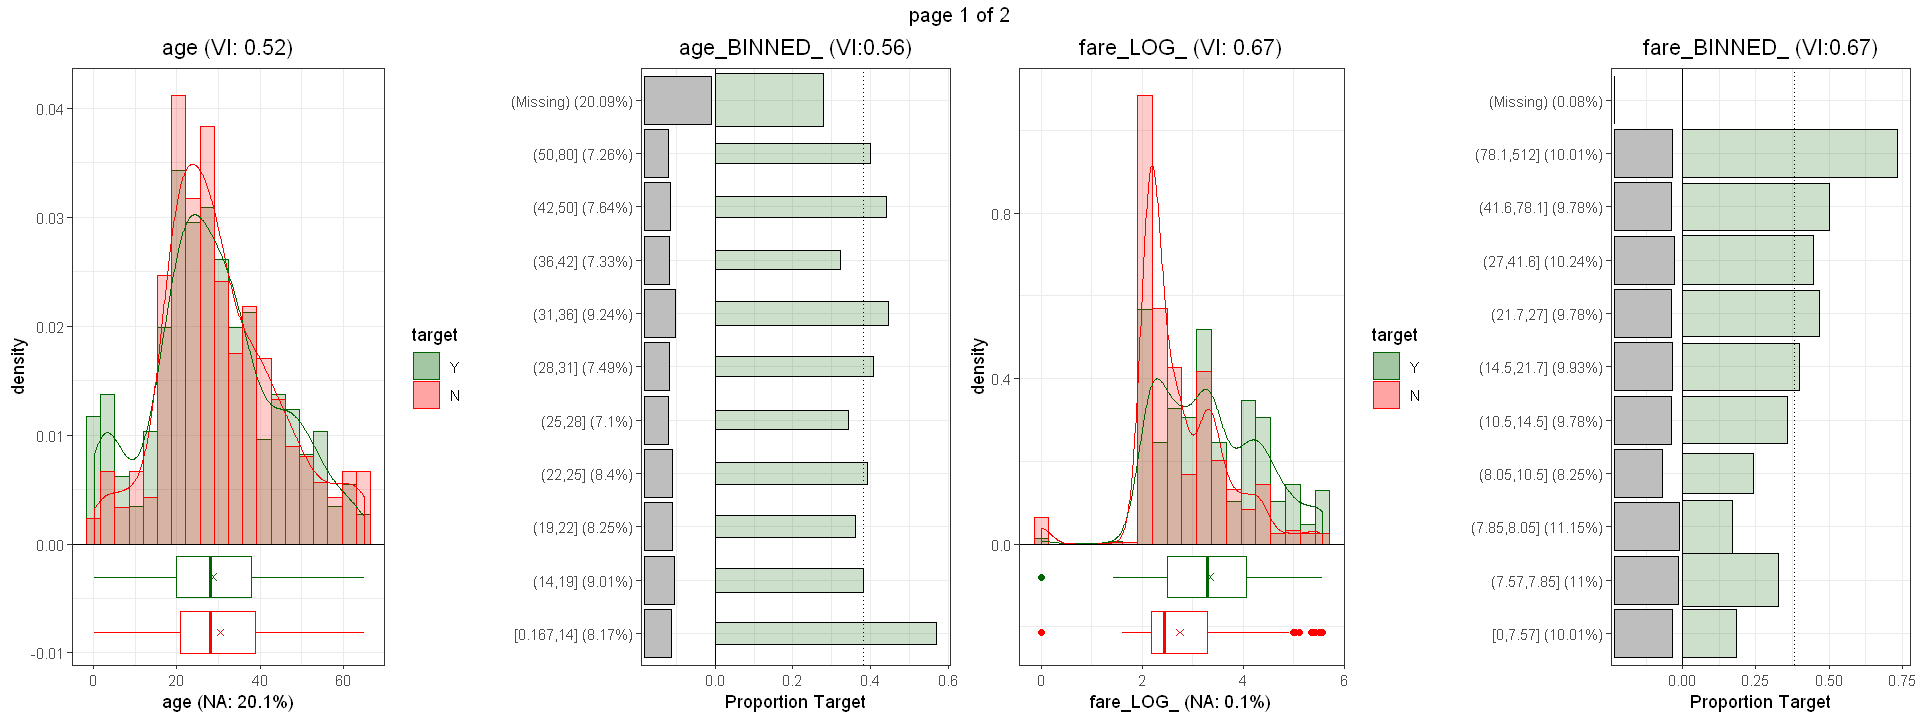

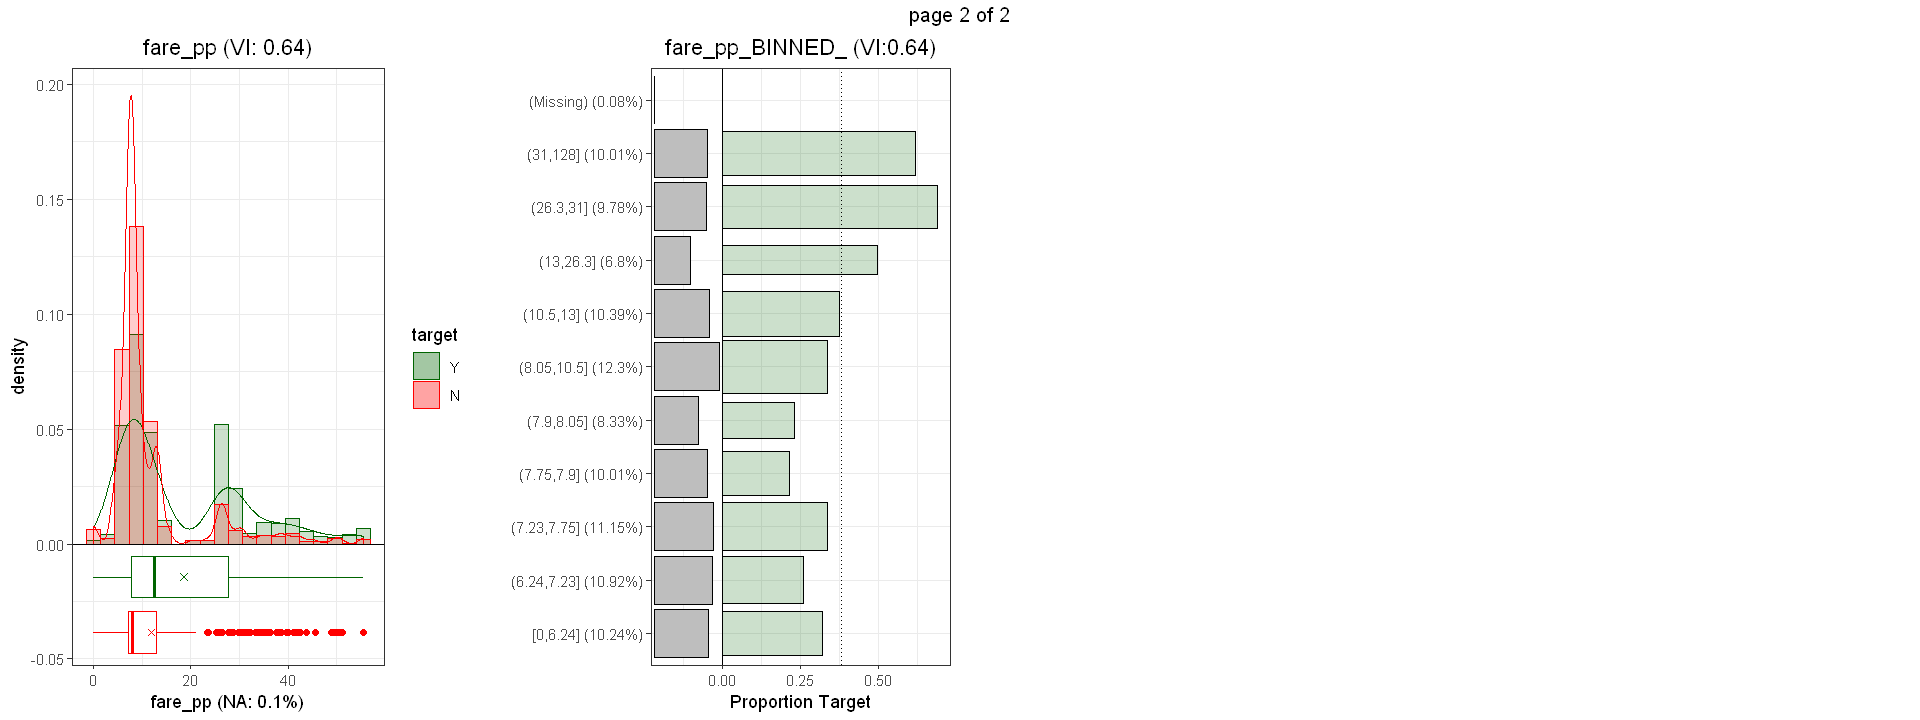

In [15]:
# Univariate variable importance: with random imputation!
varimp_metr = filterVarImp(x       = map_df(df[metr], ~ hmsPM::impute(., "random")), 
                           y       = df$target, 
                           nonpara = TRUE) %>% 
  rowMeans() %>%
  .[order(., decreasing = TRUE)] %>% 
  round(2)
print(varimp_metr)
varimp_metr_binned = filterVarImp(x       = df[metr_binned], 
                                  y       = df$target, 
                                  nonpara = TRUE) %>% 
  rowMeans() %>%
  .[order(., decreasing = TRUE)] %>% 
  round(2)
print(varimp_metr_binned)

# Plot 
plots1 = map(metr, ~ hmsPM::plot_distr(x            = df[[.]],
                                       y            = df$target,
                                       feature_name = .,
                                       varimps      = varimp_metr,
                                       colors       = twocol)) #distribution plot
plots2 = map(metr_binned, ~ hmsPM::plot_distr(x            = df[[.]],
                                              y            = df$target,
                                              feature_name = .,
                                              varimps      = varimp_metr_binned,
                                              colors       = twocol,
                                              show_legend = FALSE)) #binned variable plot
plots = mapply(list, plots1, plots2) #zip plots
#options(jupyter.plot_mimetypes = "image/svg+xml")
options(jupyter.plot_mimetypes = "image/png")
options(repr.plot.width = 16, repr.plot.height = 6) #adapt this for different resolution
marrangeGrob(plots, ncol = 4, nrow = 1) #arrange plots

The following findings can be derived from the plots:
+ We see that children have a higher probability to survive. 
+ Apart from that, the **lower survial rate in case of a missing age** (see the binned age plot) pops up. Even though this effect is not huge it hints to a possible data leakage, i.e. that age was recorded after the accident with a "higher probability of response" due to survival of the passenger. This example for "information from the future" nicely corresponds to typical business data situations where special data flags are set after the event of interest and are therefore useless for predicting the future. We emphasize this issue again as it is **one of the biggest problems in real life predictive models!** Actually for the titanic data an alternative explanation can be that 3rd class passengers which have a lower survival rate (see the forthcoming analysis) have not reported their age. If this is the case you can keep the feature.   
+ This informative missing is also the reason for a higher variable importance of *age\_BINNED\_* compared to *age*, as the former comprises the informative missing as own level, but for the latter it is randomly imputed.
+ Furthermore we can identify that ***fare*** is highly predictable for the target (AUC: 0.67) which is due to a nearly linear trend. Keep in mind that this is still a **univariate influence** and might change if we adjust for the other features in the final multivarite model. E.g. the *fare* effect might be ***confounded*** by the passenger class which might be the causal reason behind this effect as first class passengers (which pay a higher fare) are nearer to the top deck and due to this reason had a higher chance to survive.  
+ Additionally we nicely see how the log trafo also rectifies the low fares showing now a gap between the zero dollar fares and the rest.  
  
  
By this discussion of just these plots you get an impression what has to be checked in real life situations with dozens of metric variables. 

<br>  
## 2.4 Correlation analysis
Now we investigate the relation between the metric features themselves by a correlation analysis.  

When using **classical regression approaches** (without any regularization by penalization) this would be a very important step as highly correlated covariates would lead to the so-called **multicollinearity** problem. As a consequence the estimates of the model parameters (i.e. the beta coefficients in the model equation) would be highly instable and the predicctive performance of the model would decrease drastically.  

In times of robust machine learning algorithms which can handle this issue, we use the correlation analysis mostly to **identify "duplicates" of variables**, which can be removed without any loss. It is not unusual that under a high amount of metric features you find several which measure the same thing, e.g. revenue-per-month and revenue-per-year, which would pop up in a correlation matrix plot.  
In such a case we remove the variable which has more missings. Therefore we directly plot the missing rate for each variable beside the variable name. Alternatively you can remove the feature which has less variance and therefore comprises less self-contained information.

Futhermore we only **plot the correlations above a cutoff value** in order to keep the plot manageable in case of many metric variables. Often we choose .97, but then only consider **correlations above .99 for the "duplicate" candidates**. For the small titanic data none of these advices are relevant.

We almost always plot the **absolute Spearman correlation**, which is based on the ranks of the variable values and is more robust against outliers than the better known Pearson correlation. Since we took care about outliers by previous steps this might not be needed, but furthermore the Spearman correlation can also better **identify non-linear (but monotone) correlations**. And we take the absolute value as for our purpose it does not make a difference if the correlation is negative or positive.

Last but not least this analysis also helps to understand the data in hand.

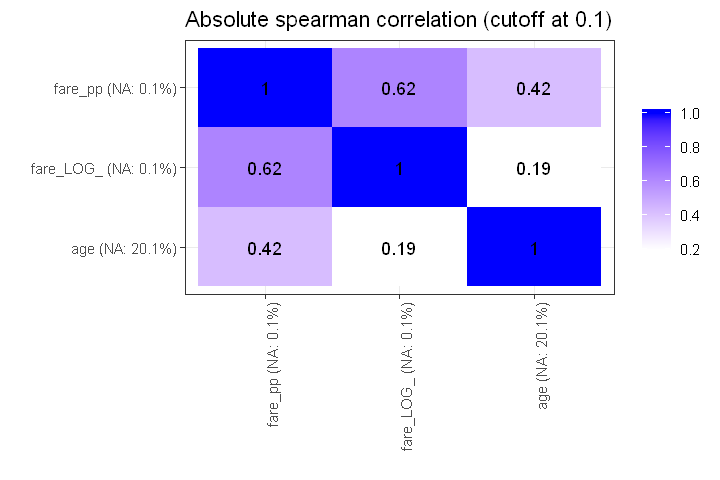

In [16]:
# Plot absolute spearman correlation for metric features
plot = plot = hmsPM::plot_corr(df_plot = df[metr],
                               cutoff  = 0.1) #plot all variables with at least one correlation above 0.1
options(repr.plot.width = 6, repr.plot.height = 4) #adapt this for different resolution
plot

In [17]:
# Remove highly/perfectly (>=99%) correlated variables (i.e. the ones with less NA!)
remove = c("xxx") #put at xxx the variables to remove
metr = setdiff(metr, c("xxx")) #remove
metr_binned = setdiff(metr_binned, 
                      paste0(c("xxx"),"_BINNED_")) #keep "binned" version in sync

<br>  
## 2.5 Time or train/test-fold dependency
Actually we are ready with the analysis of our metric features. Nearly! One final important step is lacking. 

We need to check whether the **data distributions are different between the train and test data**. Usually this occurs (in case of a timely based train/test split) due to a time dependency of the features. For typical business data this hints to a change in some process, related to business (e.g. "opened more stores in some regions") or data (e.g. "flag *xyz* now underlies a different definition"). If it occurs, it is bad news as it might degrade your predictive performance on test data and you need to decide how to handle this feature distribution change: restrict to just newer data in training or remove the time-dependant feature or add a "process-has-changed-here"-flag? There is no default solution here. You need to decide case-by-case.

To check the dependencies we just use our usual metric feature distribution plot, but now take the **fold information as the target**. Then we just plot the features with a variable importance (AUC regarding the new target) above a threshold.

If you also have a detailed time variable like date, **a better alternative** is to treat the date as a new metric target and create the same plots as for a regression task (not shown in this notebook).

For the titanic data our random split just results in some minor dependencies due to random variability which is below the threshold.

In [18]:
# Univariate variable importance (again ONLY for non-missing observations!) for time/fold dependency
df$fold_test = factor(ifelse(df$fold == "test", "Y", "N")) #new target
varimp_metr_fold = filterVarImp(df[metr], df$fold_test, nonpara = TRUE) %>% 
  rowMeans() %>% 
  .[order(., decreasing = TRUE)] %>% 
  round(2)
print(varimp_metr_fold)

# Plot: only variables with with highest importance above threshold
metr_toprint = names(varimp_metr_fold)[varimp_metr_fold >= 0.55] #restrict to
plots = map(metr_toprint, ~ hmsPM::plot_distr(x            = df[[.]],
                                              y            = df$fold_test,
                                              feature_name = .,
                                              target_name  = "fold_test",
                                              varimps      = varimp_metr_fold,
                                              colors       = c("blue","red")))
plots

  fare_pp fare_LOG_       age 
     0.51      0.51      0.51 


list()

<br>  
## 2.6 Missings "again", now impute
After we finished all processing of the metric variables we can now **impute missing values**. But before, we derive for each feature comprising any missing values, a separate **missing value indicator** (i.e. a binary flag) which we add to the feature vector (see next section), due to the chance that the missings can be informative (i.e. they have predictive capability with regard to the target).  

We choose a **random imputation** here becauese we are still in the investigative modus and do not want the missing indicator effect get mixed with an effect resulting from the median of a feature, wich would happen when we would use the **typical median imputation**. Be aware that for any scoring data you prepare, you never should use random imputation as this creates the chance of nonsense predictions due to imputation of an outlier which has a small but not zero probability to get chosen as imputation value.

In [19]:
# Create mising indicators
(miss = metr[map_lgl(df[metr], ~ any(is.na(.)))]) #get all metric features with missings (and print)
df[paste0("MISS_",miss)] = map(df[miss],
                               ~ as.factor(ifelse(is.na(.x), "miss", "no_miss"))) #create indicators
summary(df[,paste0("MISS_",miss)]) 

# Impute missings with randomly sampled value
df[miss] = map(df[miss], ~ hmsPM::impute(., "random"))
summary(df[metr]) #check

[1] "age"       "fare_LOG_" "fare_pp"

    MISS_age    MISS_fare_LOG_  MISS_fare_pp 
 miss   : 263   miss   :   1   miss   :   1  
 no_miss:1046   no_miss:1308   no_miss:1308  

      age            fare_LOG_        fare_pp     
 Min.   : 0.1667   Min.   :0.000   Min.   : 0.00  
 1st Qu.:21.0000   1st Qu.:2.186   1st Qu.: 7.55  
 Median :28.0000   Median :2.738   Median : 8.05  
 Mean   :29.9080   Mean   :2.977   Mean   :14.45  
 3rd Qu.:39.0000   3rd Qu.:3.474   3rd Qu.:15.03  
 Max.   :65.0000   Max.   :5.574   Max.   :55.44  

<br><br>   
 # 3. Categorical features: Explore and adapt
 In this section we do a similar analysis for the **categorical (nominal) features**. But due to the different scale, the handling of several issues are approached differently.

First of all you need to decide which ones are the categorical features. At least all variables containing any characters must be treated as nominal. But also 0/1-flags are added. Futhermore numerically coded variables where the single value has "no meaning", i.e. you cannot do any calculations with them, like for german postal codes. And it is **not unusual to also treat some clear numeric variables as categorical** in case they comprise just a small number of distinct values, e.g. a month (ranging from 1-12) or day-of-week (ranging from 1-7); in fact these are treated as ordinal as they can be sorted in a senseful way. At least the explorative plots you will see later can visualize data relations better when these kind of variables are treated as categorical. It usually also helps an elastic-net algorithm in order to model the realationship to the target in a nonlinear way.  

In case we finally decide for a **tree-based algorithm** we might switch back to the metric scale again because it would save memory (as explained in the following) and nonlinear modeling can then be accomplished also with a clear metric feature. This is already a hint that **data preprocessing in the final productive model can be different from the explorative phase**. We usually address this by the 2 attributes "explore_type" and "model_type" in our metadata (not reflected in this notebook), which can differ for some variables in the way that *explore_type = nominal* might have a different *model_type = metric* (but not vice versa).

For now this means that we also add the missing indicators (0/1-flags) to the nominal feature vector and create a quick overview.

In [20]:
# Nominal variables
nomi = df.meta_sub %>% filter(type == "nomi") %>% .$variable
df[nomi] = map(df[nomi], 
               ~ hmsPM::convert_scale(., "nomi")) #map to nominal

# Sort the ordinal variables (has only influence on ordering of levels in plots)
ordi = df.meta_sub %>% filter(type == "ordi") %>% .$variable
df[ordi] = map(df[ordi], 
               ~ hmsPM::convert_scale(., "ordi")) #map to ordinal

# Define all categorical features
cate = c(df.meta_sub %>% filter(type %in% c("nomi","ordi")) %>% .$variable, 
         paste0("MISS_",miss))
summary(df[cate])

 pclass        sex      sibsp       parch             embarked        boat                    home.dest        deck        familysize 
 1st:323   male  :843   0:891   0      :1002   Southampton:914   13     : 39   New York, NY        : 64   C      :  94   1      :790  
 2nd:277   female:466   1:319   1      : 170   Cherbourg  :270   C      : 38   London              : 14   B      :  65   2      :235  
 3rd:709                2: 42   2      : 113   Queenstown :123   15     : 37   Montreal, PQ        : 10   D      :  46   3      :159  
                        3: 20   3      :   8   NA's       :  2   14     : 33   Paris, France       :  9   E      :  41   4      : 43  
                        4: 22   4      :   6                     4      : 31   Cornwall / Akron, OH:  9   A      :  22   6      : 25  
                        5:  6   5      :   6                     (Other):308   (Other)             :639   (Other):  27   5      : 22  
                        8:  9   (Other):   4           

<br>  
## 3.1 Handling of missings and too-many-members features
Feeding categorical features into **non-tree-based** machine learning algorithms requires a so-called **"1-hot" (or "dummy") coding** for the features. This means you need to create a binary flag variable for each level of a categorical variable. For each data record only one of these flags has the value 1, all others are 0 (-> "1-hot").  
Even **most implementations of tree-based algorithms (e.g. xgboost)** need pure metric features and therefore 1-hot coded nominal variables or at least numeric variables which are differently "encoded" (as explained in more detail below). 

Apparently 1-hot coding results in **one colum per each member of a categorical variable**. In real life situations with more data than in the titanic case you need special forms of encoding (see explanations below9 of these variables with lots of members if you do not want to **run into memory space limitations**.  
This is done in one of the next code snippets: We decide to **collapse the less frequent occuring levels** to a new artficial level "\_OTHER\_" and only the top-n (with n=10 for the titanic data) members per feature are kept as is. This threshold (*topn_toomany = 10*) is somewhat arbitrary here and will be different for other data. 

For a **tree-based** algorithm there are additional other approaches to cope with too-many-member features which utilize special **encodings** (= numerical representations or mappings) as a **tree-based algorithm** is in principle also capable of handling any nominal feature as one and only one pure metric variable which apparently comprises much less space than the 1-hot coded variant. There are basically 3 variants of this "encoding into 1 numeric feature".
1. **Label encoding**: Just map the members to an arbitrary number, e.g. "level-1"->1,"level-2"->2, ...
2. **Count encoding**: First order the levels by their occurence and the map to a consecutive numer, e.g. if "level-k" comprises most records it is mapped to 1, the second most occurring level is mapped to 2 and so on. This keeps "big" members together and might help to find the signal (in case the signal is low for every member, the neighbourhood of big members helps in splitting of the few relevant, i.e. "big" ones)
3. **Target encoding**: In fact the Count encoding ordering is not doing a good job in supporting the extraction of the signel (i.e. the effect on the target). It makes more sense to respect the average target value of the members. This is done with the *Target encoding* by arranging with regard to the average target value before assigning consecutive numbers. **ATTENTION**: We use the target for this mapping. Therefore we need to do this on a subset of the data and then remove this subset as otherwise we create **data leakage**. But if you have e.g. lots of years of data you can use the old data for the encoding and leave the more actual data for the training of the model.

To make it more complicated: A tree-based algorithm might also profit from a 1-hot encoding as this makes a possible signal sharper. Think of the signal is "in the middle or the numeric representation", i.e. the target has a high or low value for a middle value of the encoded feature: with 1-hot coding it can be extracted by 1 split, but using consecutive numeric values for this variable needs two splits to extract the signal. Therefore additionally to the numerical encoding of a feature with lots of levels we 1-hot encode the top-n occurring levels (and also add the artificial "\_OTHER\_" level). And for the numerical encoding we adapt the standard count encoding in a way that we only count-encode the **non-top-n members** and map the top-n members to just one value. In other words: The 1-hot coding comprises the top-n members and the count-encoding the non-top-n. This assures that we keep as much information as possible without doubling it and help the algorithm to find the signal.

Keep in mind that for **any non-tree based algorithm we are stuck to the nominal scale and 1-hot encoding!** For the deep learning guys outside there who now protest: We do not encounter any numerical embedding approaches here. To summarise again: For Tree-based algorithms we use count encoding of the non-top-n members additional to 1-hot-encoding of top-n members, for non-Tree-based we just provide the latter.

The 1-hot coding is postponed to the application of the machine learning algorithm since an automatic support for this transformation is available there. For now we conduct the collapsing to the most frequent levels as well as the additional numerical encoding.
As as first step we just copy the too-many-members features as these are treated in two different ways (as explained above) in the following, i.e. collapsing of levels and additional encoding.


In [21]:
# Get "too many members" columns and copy these for additional encoded features (for tree based models)
topn_toomany = 10
(levinfo = map_int(df[cate], 
                   ~ length(levels(.))) %>% 
  .[order(., decreasing = TRUE)]) #get number of levels and print in decending order
(toomany = names(levinfo)[which(levinfo > topn_toomany)]) #which ones comprise too many levels
(toomany = setdiff(toomany, c("xxx","xxx"))) #set exception for important variables
df[paste0(toomany,"_ENCODED")] = df[toomany] #copy


home.dest           boat     familysize          parch           deck          sibsp         pclass       embarked            sex 
           368             27              9              8              8              7              3              3              2 
      MISS_age MISS_fare_LOG_   MISS_fare_pp 
             2              2              2

[1] "home.dest" "boat"

[1] "home.dest" "boat"

<br>  
### 3.1.1 Convert missings to own level
We can quickly care about the missings for the "standard" categorical features (i.e. the ones with less than "toomany" members: We just convert all missing to a separate factor level which we name "(Misssing)". Actually we also add the "(Missing)" member if there are no missings at all. This is consistent with the approach during productive train and score (last 2 notebooks in this series) where we proactively have to add this artifical member in order to cope with missings which first occur during scoring of new data since then the algorithm can handle these "new missing".  

In [22]:
l.tmp_enc = map(df[setdiff(cate, toomany)], ~ hmsPM::cate_encoding(x          = .,
                                                                   method     = "self",
                                                                   enc_others = TRUE,
                                                                   enc_nas    = TRUE,
                                                                   na_value   = "(Missing)"))
df[setdiff(cate, toomany)] = map(setdiff(cate, toomany), ~ hmsPM::encode(x        = df[[.]],
                                                                         encoding = l.tmp_enc[[.]]))
summary(df[setdiff(cate, toomany)])

       pclass           sex          sibsp         parch             embarked          deck        familysize       MISS_age   
 1st      :323   female   :466   0      :891   0      :1002   Southampton:914   (Missing):1014   1      :790   no_miss  :1046  
 2nd      :277   male     :843   1      :319   1      : 170   Cherbourg  :270   C        :  94   2      :235   miss     : 263  
 3rd      :709   (Missing):  0   2      : 42   2      : 113   Queenstown :123   B        :  65   3      :159   (Missing):   0  
 (Missing):  0                   4      : 22   3      :   8   (Missing)  :  2   D        :  46   4      : 43                   
                                 3      : 20   4      :   6                     E        :  41   6      : 25                   
                                 8      :  9   5      :   6                     A        :  22   5      : 22                   
                                 (Other):  6   (Other):   4                     (Other)  :  27   (Other)

<br> 
### 3.1.2 Collapse too-many-member features
Now the collapsing step is conducted for the "original" too-many-members features, i.e. we collapse the levels to only the top-n occurring ones plus an artificial "\_OTHER\_" member to which all the other non-frequent members are mapped. We also add the standard artficial "(Missing)" member.

In [23]:
l.tmp_enc = map(df[toomany], ~ hmsPM::cate_encoding(x            = .,
                                                    method       = "self_topn",
                                                    n_top_levels = topn_toomany,
                                                    other_value  = "_OTHER_",
                                                    na_value     = "(Missing)"))
df[toomany] = map(toomany, ~ hmsPM::encode(x        = df[[.]],
                                           encoding = l.tmp_enc[[.]]))
summary(df[toomany], 20)

                           home.dest          boat    
 New York, NY                   : 64   13       : 39  
 London                         : 14   C        : 38  
 Montreal, PQ                   : 10   15       : 37  
 Cornwall / Akron, OH           :  9   14       : 33  
 Paris, France                  :  9   4        : 31  
 Philadelphia, PA               :  8   10       : 29  
 Wiltshire, England Niagara Fall:  8   5        : 27  
 Winnipeg, MB                   :  8   3        : 26  
 Belfast                        :  7   11       : 25  
 Brooklyn, NY                   :  7   9        : 25  
 _OTHER_                        :601   _OTHER_  :176  
 (Missing)                      :564   (Missing):823  

<br>  
### 3.1.3 Encoding
We finally encode the copies of the too-many-member features to a numerical representation. Here we choose the count encoding but just for the non-frequent members. The top-n most frequent members are encoded to the same numeric value (e.g. to the value of 18 for the boat_ENCODED variable). This is kind of reverse to the previous step and assures that we keep all information we have but not in a double way as already explained above.

In [24]:
df[paste0(toomany,"_ENCODED")] = map(df[paste0(toomany,"_ENCODED")], ~
                                       hmsPM::encode(x        = .,
                                                     encoding = hmsPM::cate_encoding(x            = .,
                                                                                     method       = "count_others",
                                                                                     n_top_levels = topn_toomany,
                                                                                     na_value     = 0))) #create encoded features i.e. numeric representation
summary(df[paste0(toomany,"_ENCODED")], 20)

 home.dest_ENCODED  boat_ENCODED   
 Min.   :  0.00    Min.   : 0.000  
 1st Qu.:  0.00    1st Qu.: 0.000  
 Median : 21.00    Median : 0.000  
 Mean   : 98.32    Mean   : 4.932  
 3rd Qu.:175.00    3rd Qu.: 9.000  
 Max.   :359.00    Max.   :18.000  

<br>  
## 3.2 Plot the finalized features
We are finished with the processing of the nominal features.
Before plotting we list the univariate variable importance (AUC in this case) in descending order for a quick check.

In [25]:
# Univariate variable importance
(varimp_cate = filterVarImp(x       = df[cate], 
                            y       = df$target, 
                            nonpara = TRUE) %>% 
  rowMeans() %>% #rowMeans needed for multiclass target
  .[order(., decreasing = TRUE)] %>% 
  round(2))

boat            sex         pclass           deck      home.dest     familysize          parch       embarked       MISS_age 
          0.97           0.76           0.67           0.63           0.61           0.58           0.58           0.57           0.54 
         sibsp MISS_fare_LOG_   MISS_fare_pp 
          0.54           0.50           0.50

The following plot per nominal feature has some nice properties helping in understanding the data:
+ Again, we plot the **univariate variable importance** in the header.
+ The grey bar chart on the left shows the **distribution of the nominal variable** and is also reflected by the percentage values inside the brackets beside the level name. First of all this helps in identifying rare members which is important when judging the effect of the member onto the target.
+ This effect itself is visualized by the colored bars. The width of the bars are proportional to their occurence (and therefore show the same as the grey bars).
+ The vertical refernce line denotes the **base rate** of the target (38.2% survived). So you can directly see which member has an average target value above or below the overall average.
+ Be aware that the x-axis scale is NOT the same for all plots.
+ Features on an ordinal scale are shown in the correct order.

[[1]]
NULL


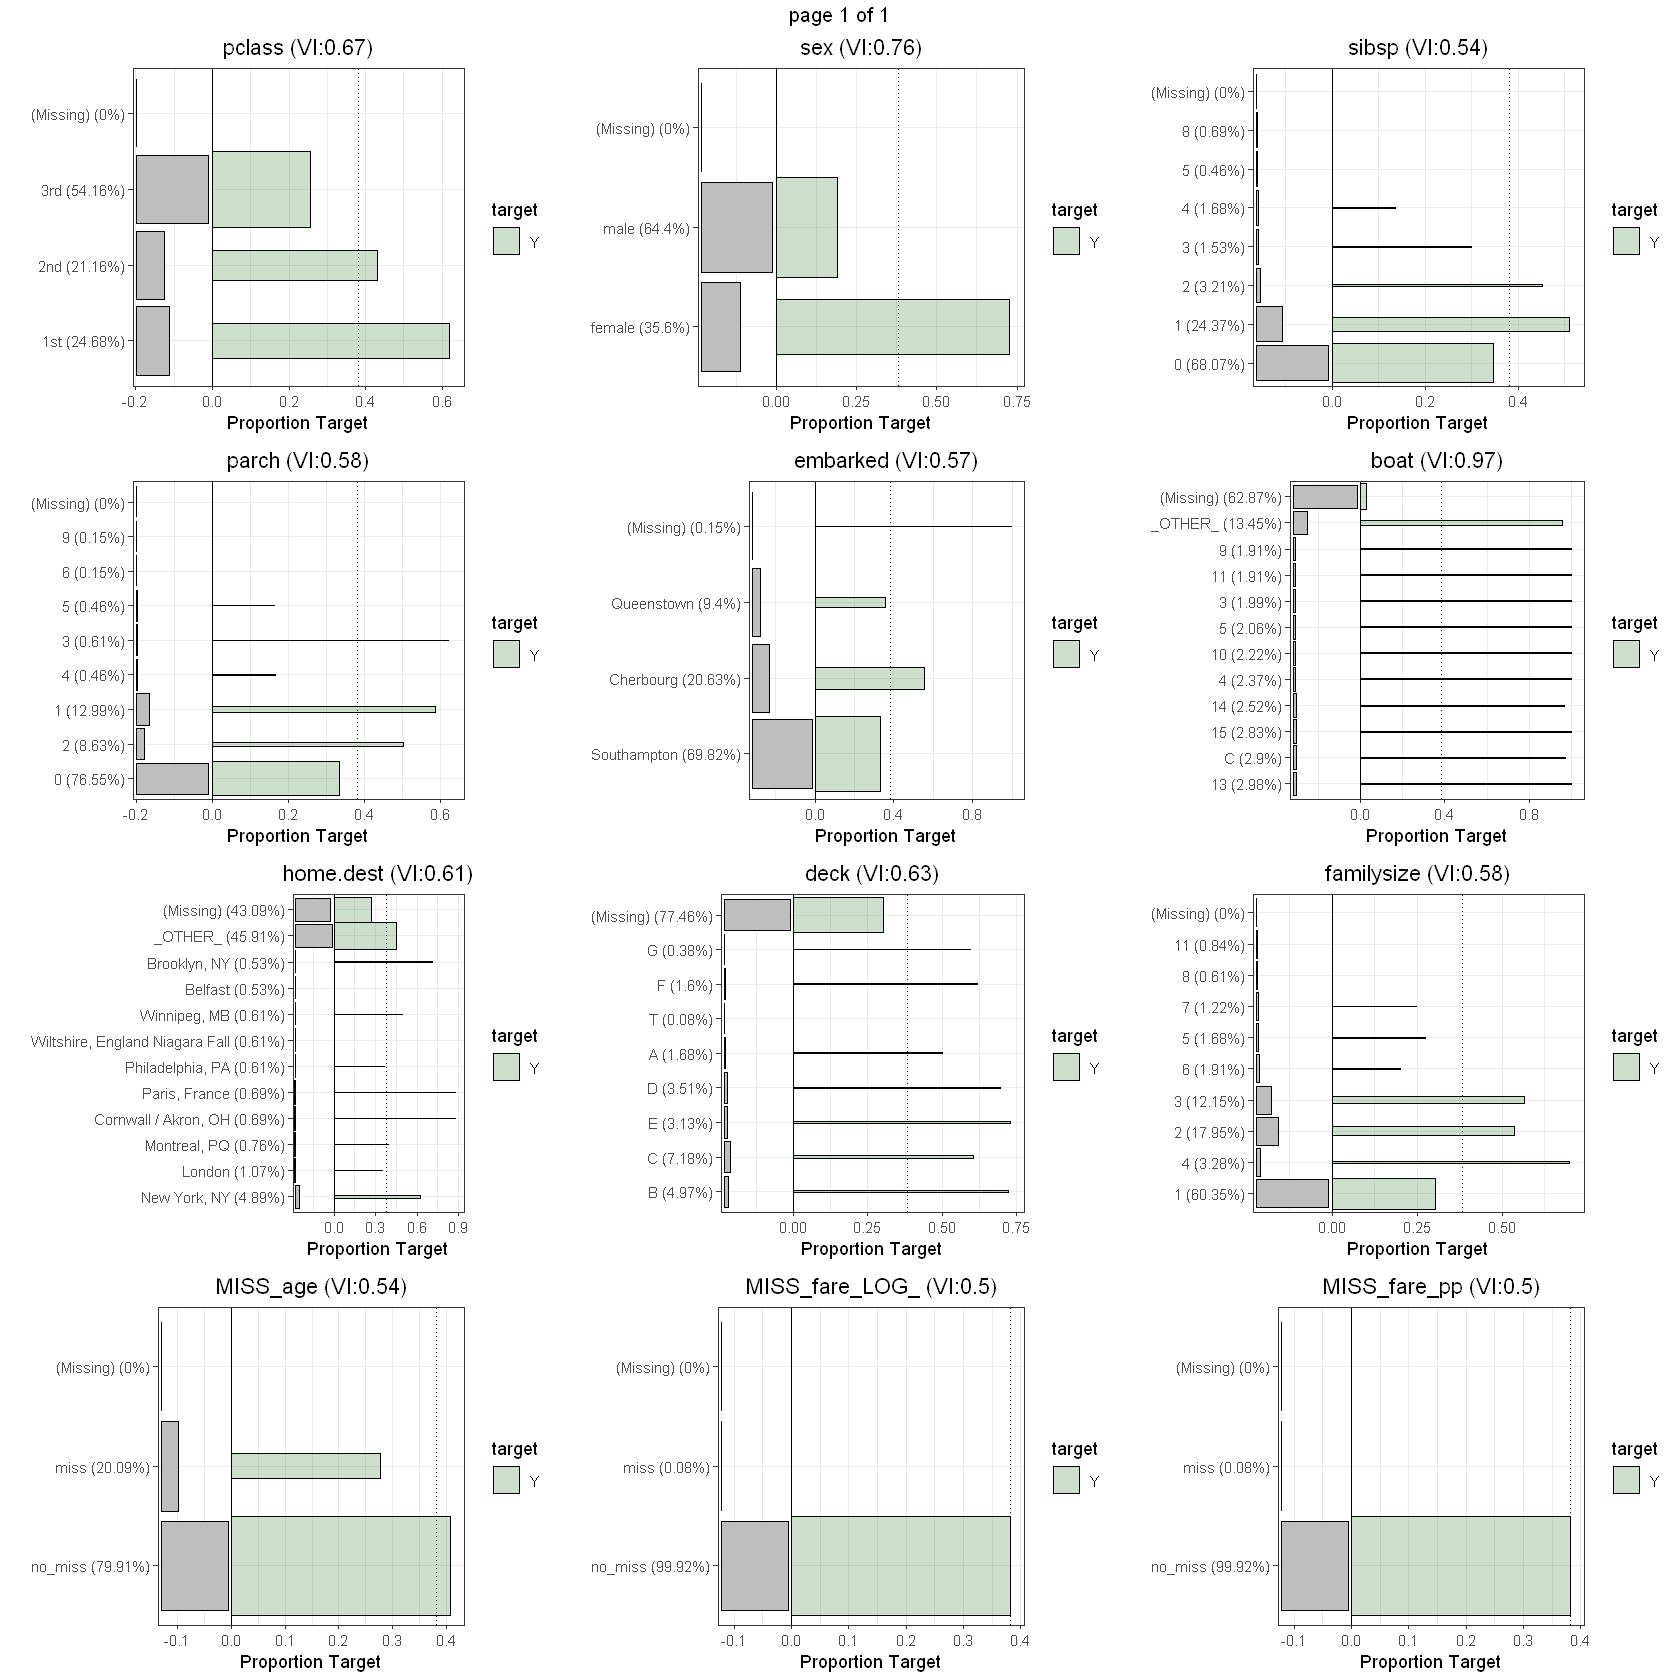

In [26]:
# Check
plots = map(cate, ~ hmsPM::plot_distr(x            = df[[.]],
                                      y            = df$target,
                                      feature_name = .,
                                      varimps      = varimp_cate,
                                      colors       = twocol,
                                      verbose      = FALSE))
#options(jupyter.plot_mimetypes = "image/svg+xml")
#options(jupyter.plot_mimetypes = "image/png")
options(repr.plot.width = 14, repr.plot.height = 14) #adapt this for different resolution
marrangeGrob(plots, ncol = 3, nrow = 4)

Lots of interesting findings can be derived from the plots. We just list some of them:
+ Passenger Class (*pclass*) and *sex* have a high impact on survival rate: Lucky Rose, sorry Jack ....
+ We see some extreme effects for *sibsp* and *parch*, i.e. zero or at least low survival rate for the members with a high value. Actually these correspond to very rare members and therefore **do not represent a real signal!**
+ *deck* and *home.dest\_OTHER\_* have **informative missings** as the probability of survival is highly reduced. Similarly to the missing age effect it is questionable whether this is not some form of data leakage (see explanations for age in chapter 2). Btw, the missing age effect can also be seen in the plot of the **missing indicator** of age (*MISS_age*).
+ But the most extreme effect occurs for *boat_OTHER_*. It seems like a perfect predictor for survival. Actually if you check what this variable means, you notice that it denotes the lifeboat and is therefore clearly **information from the future**. A passenger first must have survived before the number of the lifeboat which catched him/her is known. We need to remove this variable form the predictor (feature) set. Again we need to emphasize here, that in case you see in these plots an effect which seems to be too good to be true, all your alarm rings should start. And always be aware that this issue can come along in more subtle ways than for this easy identifiable example!

In [27]:
# Remove Self-predictors
cate = setdiff(cate, "boat")
toomany = setdiff(toomany, "boat")

<br>  
## 3.3 Correlation analysis
We have reached the investigation of **dependencies between the nominal features**.  

Basically we use a similar approach to the correlation analysis for the metric variables, with the absolute Spearman correlation exchanged by the ***(corrected) contingency coefficient***. This metric also varies between 0 and 1 with 0 denoting absolute independency and 1 absolute dependency between the features.

And like for the metric features we also only remove the ones which show a really high "correlation", **BUT only if the number of levels between the "correlated" features do NOT highly differ**. In turn this means that we keep 2 features which are highly dependant (maybe also perfectly depdendant, i.e. with a contingency coefficient equals 1), like it would happen for typical "product groups" and "product types" for instance, as one of these variables is a grouping of the other and helps the algorithm to find the signal (if it is there). But if both features comprise nearly the same number of levels we can remove one of them without any loss as both are features are kind of equal.  

For the titanic data we only see a high dependency for the missing indicator of fare\_LOG\_ and fare_pp as both represent the same information and we remove one of them.  

Be aware that we also only plot variables which have at least one "correlation" above the **cutoff**. In such a case the metric is printed in white. And variables with high dependencies are clustered together. Both helps to get the overview quicker in case of a high amount of nominal features. 

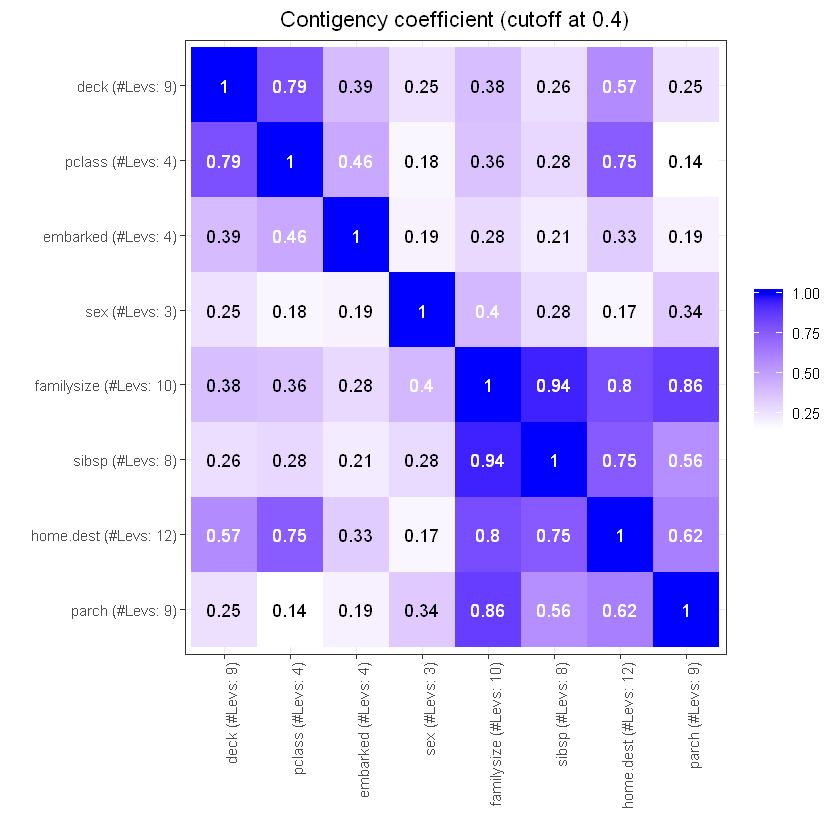

In [28]:
# Plot corrected contingency coefficient for nominal features
plot = hmsPM::plot_corr(df_plot        = df[setdiff(cate, paste0("MISS_",miss))],
                        feature_scale  = "nomi",
                        cutoff         = 0.4,
                        verbose        = FALSE) #plot all variables with at least one conitg. coeff. above 0.4
options(repr.plot.width = 7, repr.plot.height = 7) #adapt this for different resolution
plot

In [29]:
# Remove highly/perfectly (>=99%) correlated (the ones with less levels!) 
remove = c("MISS_fare_pp") 
cate = setdiff(cate, remove) #put at xxx the variables to remove

<br>  
## 3.4 Time or train/test-fold dependency for nominal features
Final step: Check the dependency of the nominal features regarding the fold split. See the explanations for the metric features above, as we are doing the same. Again no findings here since we are not dealing with a real time-based split.

In [30]:
# Univariate variable importance (again ONLY for non-missing observations!) for time/fold dependency
(varimp_cate_fold = filterVarImp(x       = df[cate],
                                 y       = df$fold_test, 
                                 nonpara = TRUE) %>% 
  rowMeans() %>%
  .[order(., decreasing = TRUE)] %>% 
 round(2))

# Plot: only variables with with highest importance above threshold
cate_toprint = names(varimp_cate_fold)[varimp_cate_fold >= 0.55]
plots = map(cate_toprint, ~ hmsPM::plot_distr(x            = df[[.]],
                                              y            = df$fold_test,
                                              feature_name = .,
                                              target_name  = "fold_test",
                                              varimps      = varimp_cate_fold,
                                              colors       = c("blue","red")))


deck            sex          parch       embarked      home.dest     familysize          sibsp         pclass       MISS_age 
          0.51           0.51           0.51           0.51           0.51           0.51           0.51           0.50           0.50 
MISS_fare_LOG_ 
          0.50

<br><br>  
## 4. Save the final state
We are finished with the exploration and adaption of our features.  

Therefore we can save the current state for the forthcoming steps of *model comparison* and *model interpretation*. For this task we save the feature names in a character vector separately for the tree-based, non-tree-based and the binned versions which we will use with different algorithms during the model comparison. As explained above only the tree-based algorithms can handle the count-encoded variables. Furhter notice the removal of the missing indicators for the binned version; this information is comprised in the newly created "(Missing)" member. The purpose behind the multiple formulas will get clearer in the next notebook.  


In [31]:
# Define final features 
features_notree = c(metr, cate)
formula_notree = paste("target", "~ -1 +", paste(features_notree, collapse = " + "))
features = c(metr, cate, paste0(toomany,"_ENCODED"))
formula = paste("target", "~ -1 +", paste(features, collapse = " + "))
features_binned = c(metr_binned, setdiff(cate, paste0("MISS_",miss))) #do not need indicators if binned variables
formula_binned = paste("target", "~ -1 +", paste(features_binned, collapse = " + "))

# Check
setdiff(features_notree, colnames(df))
setdiff(features, colnames(df))
setdiff(features_binned, colnames(df))


# Save image 
rm(df.orig, plots, plots1, plots2)
save.image(paste0(dataloc,"1_explore.rdata"))

character(0)

character(0)

character(0)